In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
frame = pd.read_csv('10x10, 10^5 images')
frame.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0,1,1,0,0,0,1,0,1,1,...,1,1,1,0,0,0,0,1,1,8
1,1,0,1,1,1,0,0,1,1,1,...,1,1,0,1,1,1,0,1,0,6
2,1,1,1,1,0,1,0,0,1,1,...,0,0,0,1,0,1,1,0,0,6
3,0,0,0,1,0,0,0,0,0,0,...,1,1,0,1,0,0,1,1,1,7
4,1,0,1,1,1,1,0,0,1,1,...,1,0,1,0,0,0,0,1,1,10


In [4]:
print('mean y', frame['100'].mean())
print('median y', frame['100'].median())
print('max y', frame['100'].max())
print('min y', frame['100'].min())

mean y 10.22975
median y 10.0
max y 24
min y 1


In [5]:
# Собственно если совсем ничего не делать
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print('mse', mean_squared_error(frame['100'], [frame['100'].mean()] * frame.shape[0]))
print('mae', mean_absolute_error(frame['100'], [frame['100'].median()] * frame.shape[0]))

mse 9.2851049375
mae 2.42221


In [6]:
X = frame.drop('100', axis = 1)
y = frame['100']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Maybe KNN

In [12]:
#Собственно если сделать чуть-чуть
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

%%time
knn = KNeighborsRegressor()
param_grid_knn = {'n_neighbors': [1, 3, 5, 10, 30, 100, 1000], 'p': [1, 1.5, 2, 3]}
param_grid_knn_mini = {'n_neighbors': [5], 'p': [1]}
optimizer = GridSearchCV(knn, param_grid_mini, scoring='neg_mean_squared_error', n_jobs=-1, cv = 2)
optimizer.fit(X_train, y_train)

In [9]:
%%time
knn = KNeighborsRegressor(n_neighbors=5, p=1)
knn.fit(X_train, y_train)

CPU times: user 10 s, sys: 8 ms, total: 10 s
Wall time: 10 s


In [11]:
%%time
print(mean_squared_error(y_test[:1000], knn.predict(X_test[:1000])))

7.1814
CPU times: user 23.1 s, sys: 4 ms, total: 23.1 s
Wall time: 23.2 s


# Линейные методы

In [14]:
from sklearn.linear_model import Ridge
ridge = Ridge()
param_grid_ridge = {'alpha': [0, 0.5, 0.75, 1, 1.5, 5, 10, 50]}
optimizer = GridSearchCV(ridge, param_grid_ridge, scoring='neg_mean_squared_error', n_jobs=-1, cv = 3)

In [88]:
%%time
optimizer.fit(X_train, y_train)

CPU times: user 3.12 s, sys: 128 ms, total: 3.25 s
Wall time: 3.9 s


GridSearchCV(cv=3, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': [0, 0.5, 0.75, 1, 1.5, 5, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [89]:
print(mean_squared_error(y_test, optimizer.predict(X_test)))

5.43477903517


In [94]:
best_ridge = optimizer.best_estimator_
coefs = best_ridge.coef_
print('b = ', best_ridge.predict(np.zeros((1, 100)))[0])

b =  28.6726491708


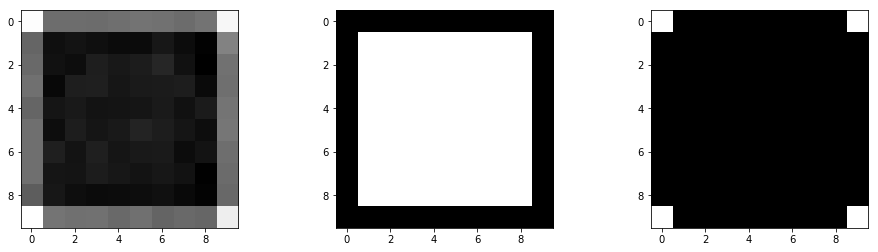

In [78]:
#Это картинка важности клеток в модели, интересно, что от угловых клеток мало что зависит
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.imshow(coefs.reshape(10, 10), cmap='gray', interpolation='nearest') 
plt.subplot(1, 3, 2)
plt.imshow(np.array([np.abs(x) > 0.3 for x in coefs.reshape(10, 10)]), cmap='gray', interpolation='nearest') 
plt.subplot(1, 3, 3)
plt.imshow(np.array([x > 0 for x in coefs.reshape(10, 10)]), cmap='gray', interpolation='nearest') 

    Из коэффициентов модели можно сделать следующие выводы:
  
   1) Угловые клетки почти не влияют на кол-во компонент, действительно это может быть только в том случае, если 3 клетки около неё черные - что не часто бывает. Причём при угловых коэффициенты больше 0 и близки к 1/8, что невероятно логично, ведь если там белая клетка (1), то с вероятностью 1/8 она даст прирост
     
   2) Во всех остальных же клетках коэффициенты меньше 0, причём по границе они не такие большие порядка -0.25, а в центре катринки около -0.42. Это говорит о том, что если клетка белая, то она скорее уменьшить кол-во компонент связности, в связи с тем, что свяжет близлежайшие к ней компоненты, причём в центре картинки сделать это более вероятно
   
   3) Также очевидно, что все признаки важны и нет смысла использовать Lasso (я попробовал лучше не стало)
   
   4) Также из-за того, что данные генерировались случайно, то модель и недумает предсказывать числа большие 30, так b = 28.6, и увеличится итоговое предсказание может макисмум до 29, благодаря положительным коэффициентам в угловых клетках.

## Трансформация признаков

In [19]:
from sklearn.preprocessing import PolynomialFeatures

In [20]:
transform = PolynomialFeatures(2)

In [21]:
%%time
X_train_poly = transform.fit_transform(X_train) #because very much memory need
X_test_poly = transform.transform(X_test)
print(X_train_poly.shape)

(80000, 5151)
CPU times: user 5.98 s, sys: 332 ms, total: 6.31 s
Wall time: 6.32 s


In [35]:
from sklearn.linear_model import Lasso
lasso = Lasso()
param_grid_lasso = {'alpha': [0.007, 0.01, 0.02]}
optimizer = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv = 3)

In [36]:
%%time
optimizer.fit(X_train_poly, y_train)

CPU times: user 5min 3s, sys: 13.9 s, total: 5min 17s
Wall time: 3min 31s


GridSearchCV(cv=3, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.007, 0.01, 0.02]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [37]:
best_lasso = optimizer.best_estimator_

In [38]:
best_lasso.alpha

0.007

In [39]:
best_lasso.coef_[best_lasso.coef_ != 0].shape[0]

756

In [64]:
# Выдаёт имена используемых признаков
np.array(transform.get_feature_names(frame.columns))[[idx for idx, x in list(enumerate([x for x in best_lasso.coef_])) if x != 0]] 

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '19', '20',
       '29', '30', '39', '40', '49', '50', '59', '60', '69', '70', '79',
       '80', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98',
       '99', '0^2', '0 1', '0 3', '0 6', '0 9', '0 10', '0 11', '0 20',
       '0 30', '0 40', '0 49', '0 69', '0 79', '0 91', '0 92', '0 93',
       '0 96', '0 97', '0 98', '1^2', '1 2', '1 3', '1 5', '1 9', '1 10',
       '1 11', '1 12', '1 20', '1 32', '1 39', '1 60', '1 69', '1 70',
       '1 79', '1 80', '1 89', '1 91', '1 94', '1 95', '1 96', '1 98',
       '2^2', '2 3', '2 4', '2 5', '2 6', '2 7', '2 8', '2 10', '2 11',
       '2 12', '2 13', '2 19', '2 20', '2 29', '2 39', '2 40', '2 49',
       '2 59', '2 60', '2 70', '2 80', '2 90', '2 91', '2 92', '2 96',
       '2 99', '3^2', '3 4', '3 5', '3 7', '3 10', '3 12', '3 13', '3 14',
       '3 19', '3 22', '3 24', '3 29', '3 39', '3 49', '3 50', '3 69',
       '3 79', '3 89', '3 90', '3 95', '4^2', '4 5', '4 6', 

In [40]:
print(mean_squared_error(y_test, optimizer.predict(X_test_poly)))

1.84834385374


Удивительный результат, получается, что с полиномиальными фичами можно добиться очень достойного результата 1.85. К сожалению, его теперь не так просто интерпретировать(